# Lab:  Nonlinear Least Squares for Modeling Materials

Nonlinear least squares (NLLS) is a widely-used method for modeling data.  In NLLS, we wish to fit a model of the form,

     yhat = g(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  We find `w` by minimizing a least-squares function 

     f(w) = \sum_i (y_i - g(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This is similar to linear least-squares, but the function `g(x,w)` may not be linear in `w`.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  

In this lab, we will implement gradient descent on NLLS in a problem of physical modeling of materials.  Specifically, we will estimate parameters for expansion of copper as a function of temperature using a real dataset.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [ ]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0','dummy'])
df.head()

,y0,x0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`. 

(236,)
(236,)


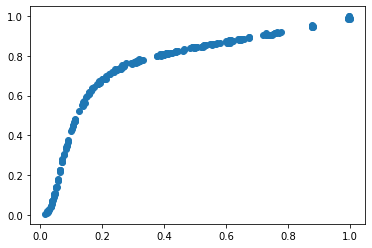

In [ ]:
# TODO
x0 = df['x0']
y0 = df['y0']
print(x0.shape)
#print("X0 = {}".format(x0))
#print("y0 = {}".format(y0))
x = x0/np.max(x0)
y = y0/np.max(y0)
print(y.shape)
plt.plot(x,y,'o')

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.02 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

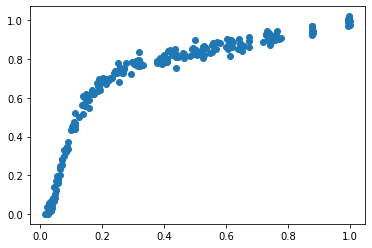

In [ ]:
# TODO
# yn = y + ...
mean = 0
stdev = 0.02
yn = y + np.random.normal(mean, stdev, y.size)
plt.plot(x, yn, 'o')

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# TODO
Xtr, Xts, ytr, yts = train_test_split(x,y, test_size=0.33)

# scal = StandardScaler()
# Xtr1 = scal.fit_transform(Xtr)
# Xts1 = scal.transform(Xts)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [ ]:
def predict(w,x):
    
    # Get the length
    d = (len(w)-1)//2
    
    # TODO.  Extract a and b from w
    a = w[0:d+1]
    b = [1] + w[d+1:]


    # TODO.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order the a and b 
    #since normally np.polyval return  ->  p[0]*x**(N-1) + p[1]*x**(N-2) + ... + p[N-2]*x + p[N-1]
    yhat = np.polyval(np.flip(a),x)/np.polyval(np.flip(b),x)
    return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i]*x[i]**d ] 

In [ ]:
d = 3

# TODO.  Create the transformed feature matrix
z = np.zeros((len(x),2*d)) #Creating a zero matrix with len(x) rows and 2d (6) columns
z.shape
for i in range(z.shape[0]):
  z[i,:] = np.hstack((x[i]**np.arange(1,d+1),y[i]*x[i]**np.arange(1,d+1)))
print(z)
# TODO.  Fit with parameters with linear regression
regr = LinearRegression()
regr.fit(z,y)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
winit1 = regr.coef_
print("Coef = {}\n".format(winit1))
winit2 = [regr.intercept_]
print("intercept = {}\n".format(winit2))

winit = np.concatenate((winit2, winit1))
print("winit = {}".format(winit))

[[2.86633553e-02 8.21587937e-04 2.35494669e-05 8.03416788e-04
  2.30286208e-05 6.60077541e-07]
 [4.08872606e-02 1.67176808e-03 6.83540171e-05 2.99988580e-03
  1.22657113e-04 5.01511333e-06]
 [5.17725250e-02 2.68039434e-03 1.38770783e-04 7.12562805e-03
  3.68911756e-04 1.90994931e-05]
 ...
 [9.97815902e-01 9.95636574e-01 9.93462005e-01 9.97295343e-01
  9.95117152e-01 9.92943718e-01]
 [9.99260225e-01 9.98520997e-01 9.97782316e-01 9.99260225e-01
  9.98520997e-01 9.97782316e-01]
 [9.96031047e-01 9.92077847e-01 9.88140336e-01 9.88945220e-01
  9.85020143e-01 9.81110645e-01]]
Coef = [ 11.80963715 -42.25771011  34.98808982  -5.43086501  33.0469154
 -30.9067347 ]

intercept = [-0.28819154993112384]

winit = [ -0.28819155  11.80963715 -42.25771011  34.98808982  -5.43086501
  33.0469154  -30.9067347 ]


Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

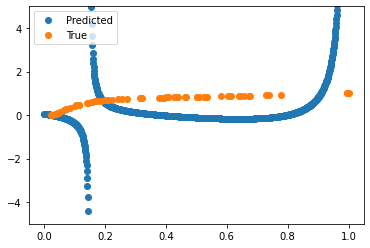

In [ ]:
# TODO
xp = np.linspace(0,1,1000)
yhat = predict(winit, xp) #Predicted
plt.plot(xp,yhat,'o')
plt.plot(Xts, yts, 'o')
plt.ylim(-5,5)
plt.legend(['Predicted','True'], loc='upper left')

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

winit = [-0.15301076  7.40768397 -3.99267034  5.50271855 -3.32254674 -4.78232607
  0.32155614]


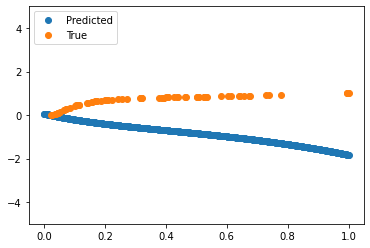

In [ ]:
# TODO.  Fit with parameters with linear regression
regr = Ridge(alpha=1e-3)
regr.fit(z, y)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
winit1 = regr.coef_
winit2 = [regr.intercept_]
winit = np.concatenate((winit2, winit1))
print("winit = {}".format(winit))

# TODO
# Plot the results as above.
xp = np.linspace(0,1,1000)
yhat = predict(winit, xp) #Predicted
plt.plot(xp,yhat,'o')
plt.plot(Xts, yts, 'o')
plt.ylim(-5,5)
plt.legend(['Predicted','True'], loc='upper left')

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [ ]:
#TEST
# d = (len(winit)-1)//2
# a = winit[0:d+1]
# b = winit[d+1:]
# print(a)
# print(b)
# znum = np.zeros([x.shape[0],d+1])
#     # TODO.  Znum[i,j] = x[i]**j
# for i in range(znum.shape[0]):
#   znum[i,:] = x[i]**np.arange(0,d+1)
# print(znum.shape)

# zden = np.zeros([x.shape[0]-1,d])
#     # TODO.  Zden[i,j] = x[i]**(j+1)
# for i in range(zden.shape[0]):
#   zden[i,:] = x[i]**np.arange(1,d+1)
# print(zden.shape)


# def feval(w,x1,y1):
        
    
#     # TODO.  Parse w
#     # Get the length
#     d = (len(w)-1)//2
    
#     # TODO.  Extract a and b from w
#     a = w[0:d+1]
#     b = w[d+1:]
    
#     znum = np.zeros([x1.shape[0], d+1])
#     # TODO.  Znum[i,j] = x[i]**j
#     for i in range(znum.shape[0]):
#         znum[i,:] = (x1[i]**np.arange(0,d+1))
#         znum[i]=znum[i].dot(a)

#     zden = np.zeros([x1.shape[0], d])
#     newcol=np.zeros([x1.shape[0],1])
#     # TODO.  Zden[i,j] = x[i]**(j+1)
#     for i in range(zden.shape[0]):
#         zden[i,:] = (x1[i]**np.arange(1,d+1))
#         zden[i]=zden[i].dot(y1[i]).dot(b)
    
#     zden=np.append(zden,newcol,1)
#     # TODO.  Compute yhat 
#     # Compute the numerator and denominator
#     yhat1 = np.zeros((zden.shape[0],1))
#     for i in range(zden.shape[0]):
#       zb=znum[i]-zden[i]
#       yhat1[i] = sum(list(zb))
    
#     #yhat=np.subtract(znum,zden)
#     #znum = znum.dot(a.T)
#     #zden = zden.dot(b.T)
#     # TODO.  Compute loss
#     y1=np.reshape(236,1)
#     f = 0.5*np.sum((y1 - yhat1)**2)
#     #f=y-yhat
#     # TODO.  Compute gradients
#     df_dz = yhat1 - y1
#     fgrad = 0
    
#     return f, fgrad


In [ ]:
def feval(w,x,y):
    d = (len(w)-1)//2
    
    # TODO.  Extract a and b from w
    a = w[0:d+1]
    b = w[d+1:]
    
    #znum = np.zeros([x.shape[0], d+1])
    # TODO.  Znum[i,j] = x[i]**j
    for i in range(0, d+1):
      if i ==0:
        znum = np.ones(x.shape[0],)
      else:
        znum = np.column_stack((znum, x**i))

    #zden = np.zeros([x.shape[0], d])
    for i in range(1, d+1):
      if i ==1:
        zden = x
      else:
        zden = np.column_stack((zden, x**i))
    
    # TODO.  Compute yhat 
    # Compute the numerator and denominator
    #yhat=np.subtract(znum,zden)
    #znum = znum.dot(a.T)
    #zden = zden.dot(b.T)
    yhat =znum.dot(a)/(1+ zden.dot(b))

    # TODO.  Compute loss
    f = 0.5*np.sum((y - yhat)**2)
    #f=y-yhat
    # TODO.  Compute gradients
    df_dz=yhat -y
    dz_da=znum/(zden.dot(b)+1)[:,None]
    dz_db=-zden*znum.dot(a)[:,None]/((1+zden.dot(b))**2)[:,None]
    dz_dw =np.column_stack((dz_da,dz_db))
    fgrad = dz_dw.T.dot(df_dz)

    return f, fgrad


Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [ ]:
# TODO
w0=winit
f0,fgrad0 =feval(w0,Xtr,ytr)
step = 1e-6
w1 = w0 + step*np.random.randn(len(w0))
f1,fgrad1 =feval(w1,Xtr,ytr)
# Predict the amount the function should have changed based on the gradient 
df_est = fgrad0.dot(w1-w0)
print("Actual f1-f0 = %12.4e" % (f1-f0))
print("Predicted f1-f0 = %12.4e" % df_est)

Actual f1-f0 =  -1.0921e-01
Predicted f1-f0 =  -1.0921e-01


In [ ]:
# # TODO
# f0, fgrad = feval(winit, x, y)
# print(f0,fgrad.shape)
# #print(fgrad)

## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

In [ ]:
# # TODO
# # fgd = ...
# nit = 10000
# step = 1e-6
# w0_v1 = winit
# flist = np.zeros((1000, 2))
# flist_v2 = []

# for it in range(nit):
#   f0, fgrad0 = feval(w0, Xtr, ytr)
#   w0_v1 = w0_v1 - step*fgrad0
#   flist[i,0] = f0
#   flist_v2.append(f0)
#   flist[i,1] = it
#   #it_list.append(it)


# ## TODO
# # fgd = ... 
# nit = 10000 
# step = 1e-6
# # Initialize 
# w0_gd = winit
# # Create history dictionary for tracking progress per iteration. # This isn't necessary if you just want the final answer, but it # is useful for debugging
# hist = []
# # Loop over iterations 
# for it in range(nit):
#   # Evaluate the function and gradient 
#   f0, fgrad0 = feval(w0_gd,Xtr,ytr)
#   # Take a gradient step 
#   w0_gd = w0_gd - step*fgrad0
#   # Save history 
#   hist.append(f0)
# t = np.arange(nit) 
# plt.semilogx(t, hist) 
# plt.grid()



def grad_opt_simp(feval, winit, xtr, ytr, lr=1e-6,nit=1000):
    """
    Simple gradient descent optimization
    
    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    winit:  Initial estimate
    lr:     learning rate
    nit:    Number of iterations
    """
    # Initialize
    w0 = winit
    
    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it 
    # is useful for debugging
    hist = {'w': [], 'f': []}
    
    # Loop over iterations
    for it in range(nit):

        # Evaluate the function and gradient
        f0, fgrad0 = feval(w0, xtr, ytr)

        # Take a gradient step
        w0 = w0 - lr*fgrad0
        
         # Save history
        hist['f'].append(f0)
        hist['w'].append(w0)

    # Convert to numpy arrays
    for elem in ('f', 'w'):
        hist[elem] = np.array(hist[elem])
    return w0, f0, hist

Text(0, 0.5, 'Training loss')

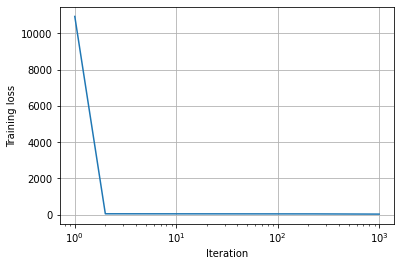

In [ ]:
# # plt.semilogx(it_list, f0_list)
# # plt.xlim(np.min(it_list), np.max(it_list))
# # plt.xlim(np.min(f0_list), np.max(f0_list))
# # plt.grid()
# flist = np.flip(flist)
# np.sort(flist[:,1])
# # plt.semilogx(flist[:,1], flist[:,0])
# # plt.grid()
# print(len(flist_v2))
# t = np.arange(nit) # 0 to 10000 
# print(len(t))
# plt.semilogx(t, flist_v2)
# plt.grid()


# Parameters
#feval = log_fun.feval
nit = 1000
lr = 1e-4

# Run the gradient descent
w, f0, hist = grad_opt_simp(feval, winit, Xtr, ytr, lr=lr, nit=nit)

# Plot the training loss
t = np.arange(nit)+1
plt.semilogx(t, hist['f'])
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Training loss')

Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

<function matplotlib.pyplot.grid>

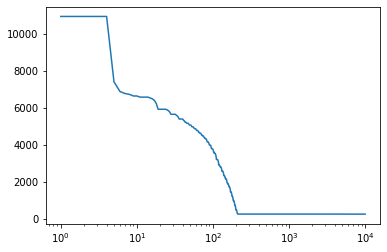

In [ ]:
# TODO
# fadapt = ...
nit = 10000
step = 1e-6  # Initial step
lr = step
w0 = winit
f0, fgrad0 = feval(w0, Xtr, ytr)
hist_adapt = []

for it in range(nit):
  w1 = w0 - lr*fgrad0

  f1, fgrad1 = feval(w1, Xtr, ytr)
  df_est = fgrad0.dot(w1-w0)

  # Check if test point passes the Armijo condition
  alpha = 0.5
  if (f1-f0 < alpha*df_est) and (f1 < f0):
    # If descent is sufficient, accept the point and increase the
    # learning rate
    lr = lr*2
    f0 = f1
    fgrad0 = fgrad1
    w0 = w1
  else:
    # Otherwise, decrease the learning rate
    lr = lr/2

  hist_adapt.append(f0)

t = np.arange(nit) + 1
plt.semilogx(t, hist_adapt)
# plt.semilogx(t, hist['f'])
plt.grid


Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

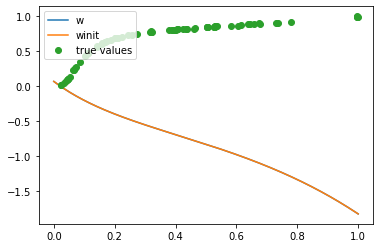

In [ ]:
# TODO
xp = np.linspace(0,1,1000)
yhat_grad = predict(winit, xp)
yhat_ridge = predict(winit, xp)
plt.plot(xp, yhat_grad)
plt.plot(xp, yhat_ridge)
plt.plot(Xts, yts, 'o')
plt.legend(['w','winit','true values'],loc='upper left')


## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-3`.   Compare the convergence of the loss function with gradient descent.  

In [ ]:
# TODO
nit = 1000
step = 1e-3
beta = 0.99

In [ ]:
# TODO
# plot yhat vs. x

## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.